# Import librairies and load Train/Test sets

## Import librairies

In [1]:
# We import the useful libraries
import numpy as np
import pandas as pd
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#Model selection, preprocessing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

#Metric 
from sklearn.metrics import mean_squared_error #Setting squared to False will return the RMSE.(sklearn>=0.22.0)

#Set options and styles
warnings.filterwarnings('ignore')
sns.set_theme(palette=sns.color_palette('Paired'),style='whitegrid')
pd.set_option('display.max_column',None)

## Load Train/Test sets

In [2]:
# Read in the dataset as a dataframe
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

# Exploratory Data Analysis

Our EDA main objectives will be to :
- Understand the variables and the relationships between them;
- Understand how the variables relate to the SalePrice;
- Detect possible outliers, missing values

## Train Set

In [3]:
# Display the first five rows of the train set
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Target Variable : SalePrice

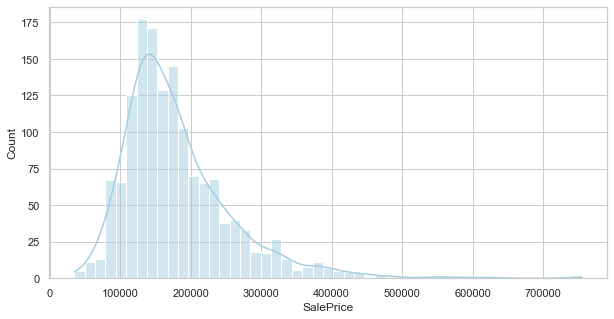

In [4]:
#Plot the distribution of the target variable
plt.figure(figsize=(10,5))
sns.histplot(x=df_train['SalePrice'], kde=True)
plt.show()

In [5]:
# Skew and kurt
print(f'Mean : {df_train["SalePrice"].mean()}')
print(f'Skewness : {df_train["SalePrice"].skew()}')
print(f'Kurtosis : {df_train["SalePrice"].kurt()}')

Mean : 180921.19589041095
Skewness : 1.8828757597682129
Kurtosis : 6.536281860064529


- The SalePrice is skewed to the right. This is a problem because most ML models don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.

In [6]:
# log(1+x) transform
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

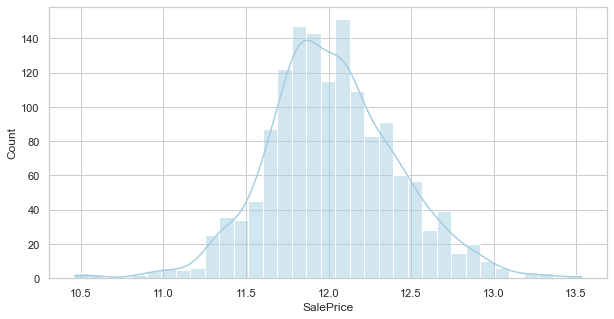

In [7]:
#Plot the NEW distribution of the target variable
plt.figure(figsize=(10,5))
sns.histplot(x=df_train['SalePrice'], kde=True)
plt.show()

In [8]:
# Skew and kurt
print(f'Mean : {df_train["SalePrice"].mean()}')
print(f'Skewness : {df_train["SalePrice"].skew()}')
print(f'Kurtosis : {df_train["SalePrice"].kurt()}')

Mean : 12.024057394918371
Skewness : 0.12134661989685329
Kurtosis : 0.809519155707878


- The SalePrice is now normally distributed.

## Features

<AxesSubplot:>

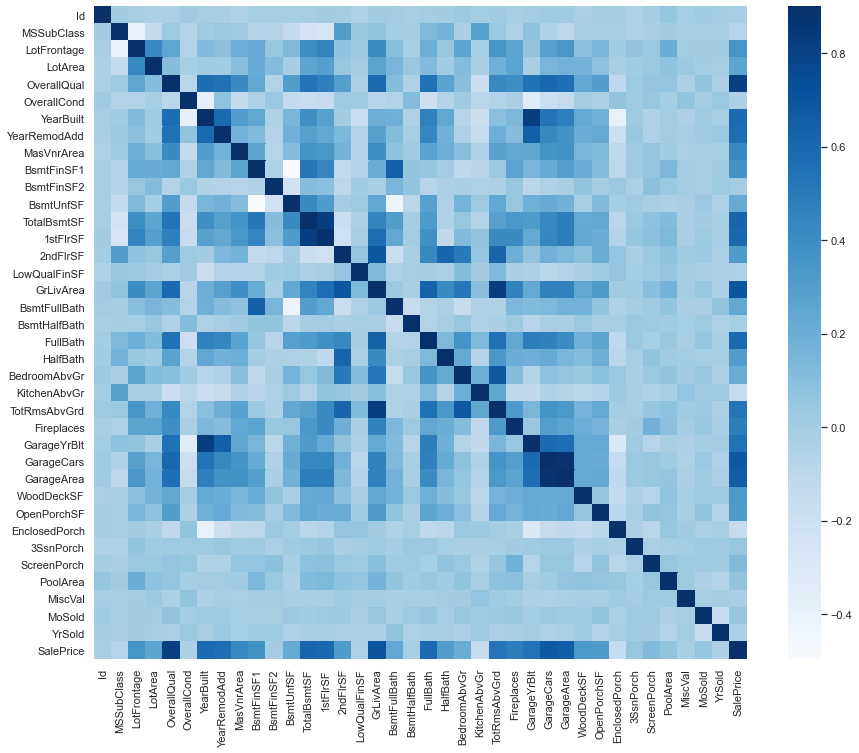

In [9]:
plt.subplots(figsize=(15,12))
sns.heatmap(df_train.corr(), vmax=0.9, cmap="Blues", square=True)

 - Let's plot how SalePrice relates to some of the features in the dataset

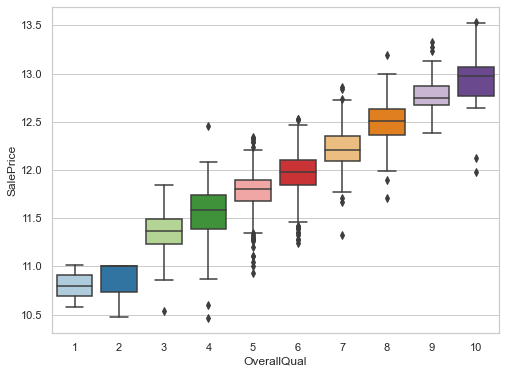

In [10]:
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=df_train['OverallQual'], y="SalePrice", data=data)

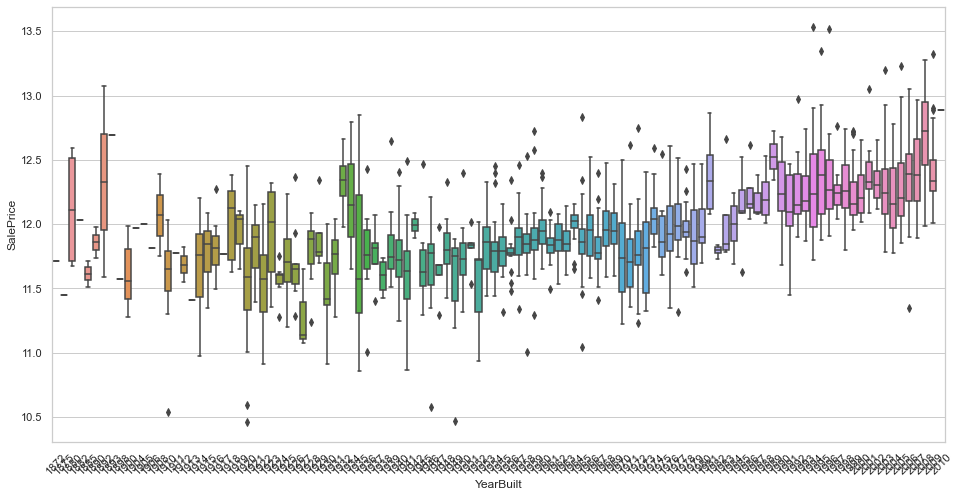

In [11]:
data = pd.concat([df_train['SalePrice'], df_train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=df_train['YearBuilt'], y="SalePrice", data=data)
plt.xticks(rotation=45);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


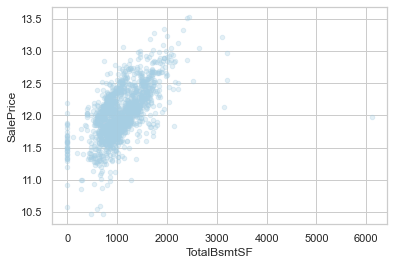

In [12]:
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


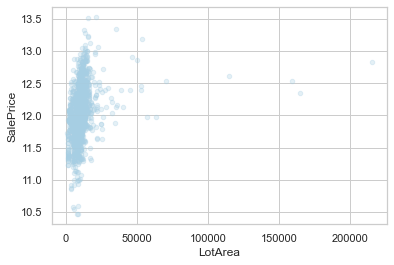

In [13]:
data = pd.concat([df_train['SalePrice'], df_train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


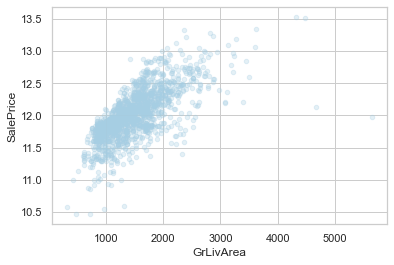

In [14]:
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3);

# Feature Engineering

In [15]:
# Remove outliers
df_train.drop(df_train[(df_train['OverallQual']<5) & (df_train['SalePrice']>12.2)].index, inplace=True)
df_train.drop(df_train[(df_train['GrLivArea']>4500) & (df_train['SalePrice']<12.6)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [16]:
# Split features and labels
X_train, y_train = df_train.drop(['SalePrice', 'Id'], axis=1), df_train['SalePrice'].reset_index(drop=True)
X_test = df_test.drop(['Id'], axis=1)

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([X_train, X_test]).reset_index(drop=True)
all_features.shape

(2916, 79)

In [17]:
X_test.shape

(1459, 79)

## Fill missing values

In [18]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.42),
 ('FireplaceQu', 48.7),
 ('LotFrontage', 16.63),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

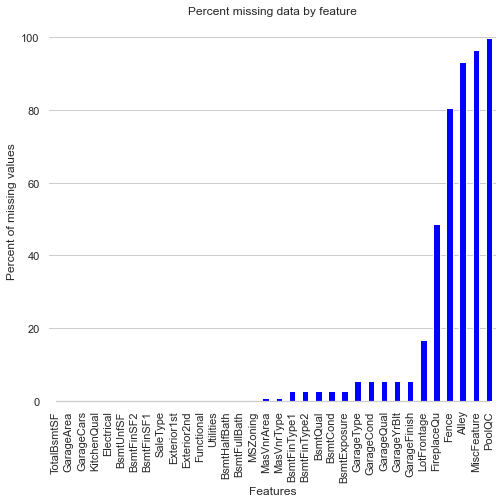

In [19]:
# Visualize missing values

f, ax = plt.subplots(figsize=(8, 7))
missing = round(all_features.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [20]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [21]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [22]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

## Fix skewed features

In [23]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

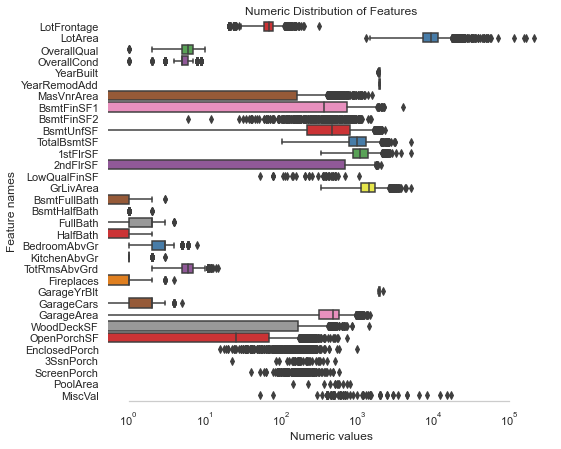

In [24]:
# Create box plots for all numeric features
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [25]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.935910
PoolArea         17.685603
LotArea          13.262550
LowQualFinSF     12.082427
3SsnPorch        11.370087
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
dtype: float64

We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that lets us normalize data.

In [26]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

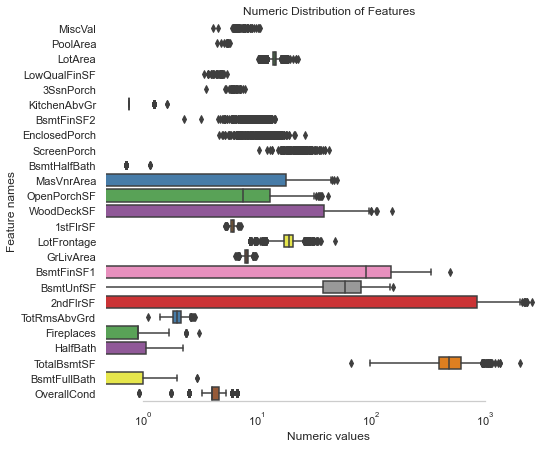

In [27]:
# Let's make sure we handled all the skewed values
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

- All the features look fairly normally distributed now.

## Create interesting features

ML models have trouble recognizing more complex patterns (and we're staying away from neural nets for this competition), so let's help our models out by creating a few features based on our intuition about the dataset, e.g. total area of floors, bathrooms and porch area of each house.

In [28]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Feature transformations
Let's create more features by calculating the log and square transformations of our numerical features. We do this manually, because ML models won't be able to reliably tell if log(feature) or feature^2 is a predictor of the SalePrice.

In [29]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [30]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Encode categorical features

Numerically encode categorical features because most models can only handle numerical features.

In [31]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2916, 379)

In [32]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po

In [33]:
all_features.shape

(2916, 379)

In [34]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

## Recreate training and test sets

In [35]:
X_train = all_features.iloc[:len(X_train), :]
X_test = all_features.iloc[len(X_train):, :]
X_train.shape, X_test.shape

((1457, 378), (1459, 378))

Visualize some of the features we're going to train our models on.

# Modelling

## Setup cross validation and define error metrics

In [38]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [40]:
# Define error metrics
def rmsle(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def cv_rmse(model, X=X_train):
    rmse = abs(cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=kf))
    return (rmse)

## Setup models

In [51]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       #verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

## Train models

### Get cross validation scores for each model

In [42]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] baggi

In [43]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[14:38:40] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:12] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:52] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:02] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:15] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:32] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:46] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is no

In [44]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1094 (0.0177)


In [45]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1099 (0.0151)


In [46]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1372 (0.0157)


In [47]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1128 (0.0155)


### Fit the models

In [49]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

lightgbm
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [54]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

xgboost


In [55]:
print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

Svr


In [56]:
print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

Ridge


In [57]:
print('RandomForest')
rf_model_full_data = rf.fit(X_train, y_train)

RandomForest


In [58]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

GradientBoosting


## Blend models and get predictions

In [59]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.25 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.15 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.2 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)))

In [63]:
# Get final predictions from the blended model
blended_score = rmsle(y_train, blended_predictions(X_train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07451777037955198


## Identify the best performing model

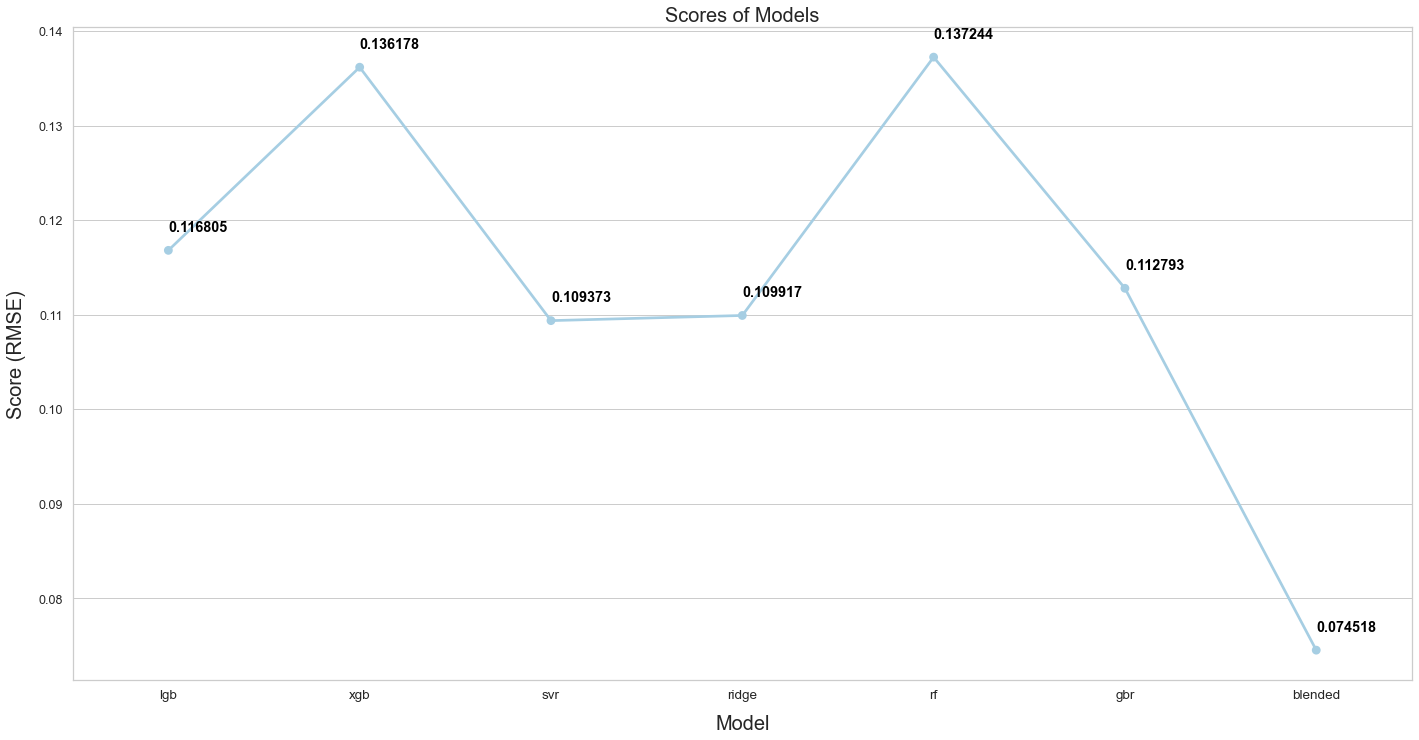

In [64]:
# Plot the predictions for each model
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

## Submit predictions

In [65]:
# Save the results
submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': np.floor(np.expm1(blended_predictions(X_test)))})
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv('submission1.csv', index=False)
# Scale predictions
submission['SalePrice'] *= 1.001619
submission.to_csv("submission2.csv", index=False)

print("The results successfully saved")

The results successfully saved
